<a href="https://colab.research.google.com/github/dragosconst/Anomaly-Detection/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Env preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/kaggle_ag_dataset.zip" -d "/content/data/"

Archive:  /content/drive/MyDrive/kaggle_ag_dataset.zip
  inflating: /content/data/test.csv  
  inflating: /content/data/train.csv  


# Imports and global constants

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 37.1 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
     |████████████████████████████████| 895 kB 41.0 MB/s 
     |████████████████████████████████| 6.6 MB 32.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#----------- func typing -----------#
from typing import List, Tuple, Dict, Union, Iterable
#----------- base libs -------------#
import time
import csv
import random
import os
import math
import copy
#----------- progress bar ----------#
from tqdm import tqdm
#----------- pickle ----------------#
import pickle
#----------- scikit ----------------#
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, plot_roc_curve, RocCurveDisplay, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
#----------- pytorch ---------------#
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
#----------- numpy -----------------#
import numpy as np
#----------- huggingface -----------#
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel, AutoConfig, AdamW, TrainingArguments, Trainer, pipeline, BertModel, BertConfig,\
                         BertForMaskedLM
#----------- plot libs -------------#
import seaborn as sn
import matplotlib.pyplot as plt
#------------ nltk -----------------#
from nltk.corpus import stopwords

sn.set_style("darkgrid")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', shuffle=False, remove=('headers', 'footers', 'quotes'))

In [ ]:
targets_to_idx= {'alt.atheism': 0,
 'comp.graphics': 1,
 'comp.os.ms-windows.misc': 2,
 'comp.sys.ibm.pc.hardware': 3,
 'comp.sys.mac.hardware': 4,
 'comp.windows.x': 5,
 'misc.forsale': 6,
 'rec.autos': 7,
 'rec.motorcycles': 8,
 'rec.sport.baseball': 9,
 'rec.sport.hockey': 10,
 'sci.crypt': 11,
 'sci.electronics': 12,
 'sci.med': 13,
 'sci.space': 14,
 'soc.religion.christian': 15,
 'talk.politics.guns': 16,
 'talk.politics.mideast': 17,
 'talk.politics.misc': 18,
 'talk.religion.misc': 19}

In [ ]:
ng_train_dict = [(d, t) for d, t in zip(newsgroups_train["data"], newsgroups_train["target"])]
ng_test_dict = [(d, t) for d, t in zip(newsgroups_test["data"], newsgroups_test["target"])]

In [ ]:
train_path = '/content/data/train.csv'
test_path = '/content/data/test.csv'

Let's peek at the data:


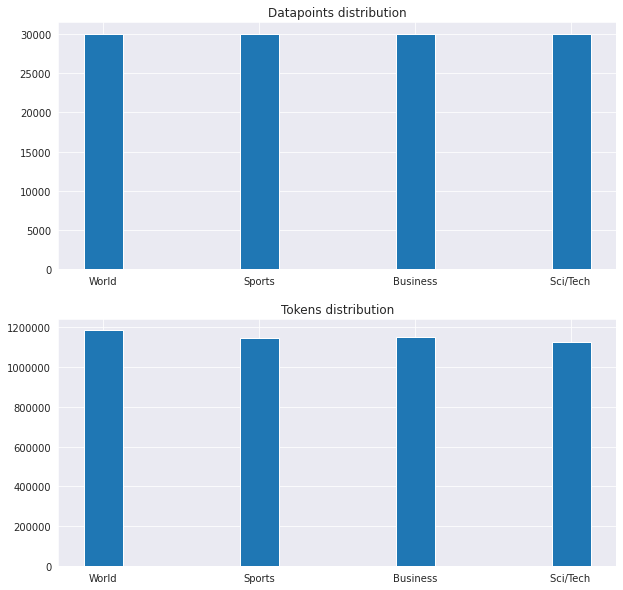

In [ ]:
class_bins = np.zeros(4)
class_tokens = np.zeros(4)
with open(train_path, "r") as f:
  reader = csv.reader(f)
  for idx, row in enumerate(reader):
    if idx == 0:
      continue
    cls, title, desc = row
    class_bins[int(cls) - 1] += 1
    title_words = len(title.split(" "))
    desc_words = len(desc.split(" ")) 
    class_tokens[int(cls) - 1] += title_words + desc_words
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
ax[0].bar(["World", "Sports", "Business", "Sci/Tech "], class_bins, width = 0.25)
ax[0].set_title("Datapoints distribution")
ax[1].bar(["World", "Sports", "Business", "Sci/Tech "], class_tokens, width = 0.25)
ax[1].ticklabel_format(style='plain', axis='y')
ax[1].set_title("Tokens distribution")
plt.show()

Huh, the dataset looks very balanced. In this case, we will arbitrarily choose one class to serve as our normal class for training, and the rest will be considered outlier classes.

In [ ]:
world_class = 1
sport_class = 2
business_class = 3
sci_class = 4

world_class_instances = []
sport_class_instances = []
business_class_instances = []
sci_class_instances = []
with open(train_path, "r") as f:
  reader = csv.reader(f)
  for idx, row in enumerate(reader):
    if idx == 0:
      continue
    cls, title, desc = row
    if int(cls) == world_class:
      world_class_instances.append(title)
      world_class_instances.append(desc)
    elif int(cls) == sport_class:
      sport_class_instances.append(title)
      sport_class_instances.append(desc)
    elif int(cls) == business_class:
      business_class_instances.append(title)
      business_class_instances.append(desc)
    elif int(cls) == sci_class:
      sci_class_instances.append(title)
      sci_class_instances.append(desc)

NameError: ignored

In [ ]:
world_class_test = []
sports_class_test = []
business_class_test = []
sci_class_test = []
with open(test_path, "r") as f:
  reader = csv.reader(f)
  for idx, row in enumerate(reader):
    if idx == 0:
      continue
    cls, title, desc = row
    if int(cls) == world_class and len(world_class_test) <= class_bins[int(cls) - 1]:# * 0.35:
      world_class_test.append(title)
      world_class_test.append(desc)
    elif int(cls) == sport_class and len(sports_class_test) <= class_bins[int(cls) - 1]:# * 0.35:
      sports_class_test.append(title)
      sports_class_test.append(desc)
    elif int(cls) == business_class and len(business_class_test) <= class_bins[int(cls) - 1]:# * 0.35:
      business_class_test.append(title)
      business_class_test.append(desc)
    elif int(cls) == sci_class and len(sci_class_test) <= class_bins[int(cls) - 1]:# * 0.35:
      sci_class_test.append(title)
      sci_class_test.append(desc)

In [ ]:
MASK_TOK_ID = AutoTokenizer.from_pretrained("bert-base-cased").mask_token_id # apparently, [MASK] has token id 103 in regular BERT

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

# Datasets and Dataloaders

In [ ]:
class NormalSet(Dataset):
  def __init__(self, class_instances: List, masked_per: float=0.15):
    self.class_instances = class_instances
    self.masked_per = masked_per
    self.tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
  def __len__(self):
    return len(self.class_instances)
  def __getitem__(self, idx):
    data_raw = self.class_instances[idx]
    tokenized_bert = self.tokenizer(data_raw, add_special_tokens=True, max_length=100, padding='max_length',
                              return_tensors='pt', truncation=True)
    # ignore padding 
    at_mask = tokenized_bert["attention_mask"]
    relevant_tokens_num = len(at_mask[at_mask == 1]) - 2 # [CLS] and [SEP] shouldn't be masked, probably
    # get mask
    masked_tokens_num = math.floor(relevant_tokens_num * self.masked_per)
    masks = np.random.randint(low=1, high=relevant_tokens_num + 1, size=masked_tokens_num) # [CLS] and [SEP] should only be the first and last tokens
    data_tokens = []
    targets_tokens = []
    # mask the inputs and build the new data and targets
    for idx, tok_id in enumerate(tokenized_bert["input_ids"][0]):
      tok_id = tok_id.item() # tok_ids end up as being one-element tensors because pytorch always returns a tensor when indexing a tensor, for some reason
      gt_tok = -100 # ignore non-masked
      if idx in masks:
        gt_tok = tok_id
        tok_id = MASK_TOK_ID
      targets_tokens.append(gt_tok)
      data_tokens.append(tok_id)
    data_tokens = torch.as_tensor(data_tokens)
    targets_tokens = torch.as_tensor(targets_tokens)

    return data_tokens, targets_tokens

In [ ]:
class TestSet(Dataset):
  def __init__(self, inliers: List, outliers: List):
    self.inliers = inliers
    self.outliers = outliers
    self.class_instances = self.inliers + self.outliers
    self.stop_words = set(stopwords.words('english'))
    self.labels = len(self.inliers) * [1] + len(self.outliers) * [0]

    self.tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

  def __len__(self):
    return len(self.class_instances)

  def __getitem__(self, idx):
    text = self.class_instances[idx]
    label = self.labels[idx]
    
    # text = " ".join([w for w in text.split(" ") if w not in self.stop_words])
    
    tokenized_bert = self.tokenizer(text, add_special_tokens=True, max_length=400, padding='max_length',
                              return_tensors='pt', truncation=True)
    
    return tokenized_bert["input_ids"], torch.tensor(label)

In [ ]:
class NewsgroupsNormal(Dataset):
    def __init__(self, group_id: int, groups:List, masked_per: float, news_set: Dict):
        self.group_id = group_id
        self.masked_per = masked_per
        self.news_set = [news for news in news_set if news[1] in groups[group_id]]
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
        self.stop_words = set(stopwords.words('english'))
    def __len__(self):
        return len(self.news_set)
    def __getitem__(self, idx):
        news = self.news_set[idx]
        text = news[0]
        # text = " ".join([w for w in text.split(" ") if w not in self.stop_words])

        tokenized_bert = self.tokenizer(text, add_special_tokens=True, max_length=350, padding='max_length',
                              return_tensors='pt', truncation=True)    # ignore padding 
        at_mask = tokenized_bert["attention_mask"]
        relevant_tokens_num = len(at_mask[at_mask == 1]) - 2 # [CLS] and [SEP] shouldn't be masked, probably
        # get mask
        masked_tokens_num = math.floor(relevant_tokens_num * self.masked_per)
        masks = np.random.randint(low=1, high=relevant_tokens_num + 1, size=masked_tokens_num) # [CLS] and [SEP] should only be the first and last tokens
        data_tokens = []
        targets_tokens = []
        # mask the inputs and build the new data and targets
        for idx, tok_id in enumerate(tokenized_bert["input_ids"][0]):
            tok_id = tok_id.item() # tok_ids end up as being one-element tensors because pytorch always returns a tensor when indexing a tensor, for some reason
            gt_tok = -100 # ignore non-masked
            if idx in masks:
                gt_tok = tok_id
                tok_id = MASK_TOK_ID
            targets_tokens.append(gt_tok)
            data_tokens.append(tok_id)
        data_tokens = torch.as_tensor(data_tokens)
        targets_tokens = torch.as_tensor(targets_tokens)

        return data_tokens, targets_tokens

### AG News objects

In [ ]:
world_set = NormalSet(business_class_instances)
ds_world_train, ds_world_valid = torch.utils.data.random_split(world_set, [int(len(world_set) * 0.8), int(len(world_set) * 0.2)])
sport_set = NormalSet(sport_class_instances)
ds_sports_train, ds_sports_valid = torch.utils.data.random_split(sport_set, [int(len(sport_set) * 0.8), int(len(sport_set) * 0.2)])
business_set = NormalSet(business_class_instances)
ds_business_train, ds_business_valid = torch.utils.data.random_split(business_set, [int(len(business_set) * 0.8), int(len(business_set) * 0.2)])
sci_set = NormalSet(sport_class_instances)
ds_sci_train, ds_sci_valid = torch.utils.data.random_split(sci_set, [int(len(sci_set) * 0.8), int(len(sci_set) * 0.2)])

BATCH_SIZE=40
dl_world_train = DataLoader(
    ds_world_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
dl_world_valid = DataLoader(
  ds_world_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
dl_sports_train = DataLoader(
    ds_sports_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
dl_sports_valid = DataLoader(
  ds_sports_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
dl_business_train = DataLoader(
    ds_business_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
dl_business_valid = DataLoader(
  ds_business_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
dl_sci_train = DataLoader(
    ds_sci_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
dl_sci_valid = DataLoader(
  ds_sci_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
world_test = TestSet(world_class_test, sports_class_test + business_class_test + sci_class_test)
sports_test = TestSet(sports_class_test, world_class_test + business_class_test + sci_class_test)
business_test = TestSet(business_class_test, world_class_test + sports_class_test + sci_class_test)
sci_test = TestSet(sci_class_test, world_class_test + sports_class_test + business_class_test)

BATCH_SIZE=40
dl_world_test = DataLoader(
    world_test, batch_size=BATCH_SIZE, num_workers=6
)
dl_sports_test = DataLoader(
    sports_test, batch_size=BATCH_SIZE, num_workers=6
)
dl_business_test = DataLoader(
    business_test, batch_size=BATCH_SIZE, num_workers=6
)
dl_world_test = DataLoader(
    sci_test, batch_size=BATCH_SIZE, num_workers=6
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 20Newsgroups objects

In [ ]:
COMP_CLASS = 0
REC_CLASS = 1
SCI_CLASS = 2
MISC_CLASS = 3
POL_CLASS = 4
REL_CLASS = 5
groups = [
    [targets_to_idx['comp.graphics'], targets_to_idx['comp.os.ms-windows.misc'], targets_to_idx['comp.sys.ibm.pc.hardware'], targets_to_idx['comp.sys.mac.hardware'], targets_to_idx['comp.windows.x']],
    [targets_to_idx['rec.autos'], targets_to_idx['rec.motorcycles'], targets_to_idx['rec.sport.baseball'], targets_to_idx['rec.sport.hockey']],
    [targets_to_idx['sci.crypt'], targets_to_idx['sci.electronics'], targets_to_idx['sci.med'], targets_to_idx['sci.space']],
    [targets_to_idx['misc.forsale']],
    [targets_to_idx['talk.politics.misc'], targets_to_idx['talk.politics.guns'], targets_to_idx['talk.politics.mideast']],
    [targets_to_idx['talk.religion.misc'], targets_to_idx['alt.atheism'], targets_to_idx['soc.religion.christian']]
]

In [ ]:
comp_set = NewsgroupsNormal(COMP_CLASS, groups, 0.15, ng_train_dict)
ds_comp_train, ds_comp_valid = torch.utils.data.random_split(comp_set, [math.floor(len(comp_set) * 0.8), math.ceil(len(comp_set) * 0.2)])
sci_set20 = NewsgroupsNormal(SCI_CLASS, groups, 0.15, ng_train_dict)
ds_sci20_train, ds_sci20_valid = torch.utils.data.random_split(sci_set20, [math.floor(len(sci_set20) * 0.8), math.ceil(len(sci_set20) * 0.2)])
rec_set = NewsgroupsNormal(REC_CLASS, groups, 0.15, ng_train_dict)
ds_rec_train, ds_rec_valid = torch.utils.data.random_split(rec_set, [math.floor(len(rec_set) * 0.8), math.ceil(len(rec_set) * 0.2)])
misc_set = NewsgroupsNormal(MISC_CLASS, groups, 0.15, ng_train_dict)
ds_misc_train, ds_misc_valid = torch.utils.data.random_split(misc_set, [math.floor(len(misc_set) * 0.8), math.ceil(len(misc_set) * 0.2)])
pol_set = NewsgroupsNormal(POL_CLASS, groups, 0.15, ng_train_dict)
ds_pol_train, ds_pol_valid = torch.utils.data.random_split(pol_set, [math.floor(len(pol_set) * 0.8), math.ceil(len(pol_set) * 0.2)])
rel_set = NewsgroupsNormal(REL_CLASS, groups, 0.15, ng_train_dict)
ds_rel_train, ds_rel_valid = torch.utils.data.random_split(rel_set, [math.floor(len(rel_set) * 0.8), math.ceil(len(rel_set) * 0.2)])

BATCH_SIZE=25
dl_comp_train = DataLoader(
    ds_comp_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
dl_comp_valid = DataLoader(
  ds_comp_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
dl_sci20_train = DataLoader(
    ds_sci20_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
dl_sci20_valid = DataLoader(
  ds_sci20_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
dl_rec_train = DataLoader(
    ds_rec_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
dl_rec_valid = DataLoader(
  ds_rec_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
dl_misc_train = DataLoader(
    ds_misc_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
dl_misc_valid = DataLoader(
  ds_misc_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
dl_pol_train = DataLoader(
    ds_pol_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
dl_pol_valid = DataLoader(
  ds_pol_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
dl_rel_train = DataLoader(
    ds_rel_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
dl_rel_valid = DataLoader(
  ds_rel_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)

In [ ]:
keep_factor=100/25
comp_set_test = [news[0] for news in ng_test_dict if news[1] in groups[COMP_CLASS]]
comp_set_test = random.sample(comp_set_test, int(len(comp_set_test)/keep_factor))
sci20_set_test = [news[0] for news in ng_test_dict if news[1] in groups[SCI_CLASS]]
sci20_set_test = random.sample(sci20_set_test, int(len(sci20_set_test)/keep_factor))
rec_set_test = [news[0] for news in ng_test_dict if news[1] in groups[REC_CLASS]]
rec_set_test = random.sample(rec_set_test, int(len(rec_set_test)/keep_factor))
misc_set_test = [news[0] for news in ng_test_dict if news[1] in groups[MISC_CLASS]]
misc_set_test = random.sample(misc_set_test, int(len(misc_set_test)/keep_factor))
pol_set_test = [news[0] for news in ng_test_dict if news[1] in groups[POL_CLASS]]
pol_set_test = random.sample(pol_set_test, int(len(pol_set_test)/keep_factor))
rel_set_test = [news[0] for news in ng_test_dict if news[1] in groups[REL_CLASS]]
rel_set_test = random.sample(rel_set_test, int(len(rel_set_test)/keep_factor))


comp_test = TestSet(comp_set_test, sci20_set_test + rec_set_test + misc_set_test + pol_set_test + rel_set_test)
sci20_test = TestSet(sci20_set_test, comp_set_test + rec_set_test + misc_set_test + pol_set_test + rel_set_test)
rec_test = TestSet(rec_set_test, sci20_set_test + comp_set_test + misc_set_test + pol_set_test + rel_set_test)
misc_test = TestSet(misc_set_test, sci20_set_test + rec_set_test + comp_set_test + pol_set_test + rel_set_test)
pol_test = TestSet(pol_set_test, sci20_set_test + rec_set_test + misc_set_test + comp_set_test + rel_set_test)
rel_test = TestSet(rel_set_test, sci20_set_test + rec_set_test + misc_set_test + pol_set_test + comp_set_test)

BATCH_SIZE=5
dl_comp_test = DataLoader(
    comp_test, batch_size=BATCH_SIZE, num_workers=0
)
dl_sci20_test = DataLoader(
    sci20_test, batch_size=BATCH_SIZE, num_workers=8
)
dl_rec_test = DataLoader(
    rec_test, batch_size=BATCH_SIZE, num_workers=8
)
dl_misc_test = DataLoader(
    misc_test, batch_size=BATCH_SIZE, num_workers=0
)
dl_pol_test = DataLoader(
    pol_test, batch_size=BATCH_SIZE, num_workers=8
)
dl_rel_test = DataLoader(
    rel_test, batch_size=BATCH_SIZE, num_workers=0
)

# Create the model

In [ ]:
class AnomalyDetectionModel(nn.Module):
  def __init__(self, num_hidden_layer: int=6, num_attention_heads: int=7, intermediate_size: int=2408, hidden_size: int=602):
    super(AnomalyDetectionModel, self).__init__()

    # Get the Transformer from the huggingface server
    config = BertConfig.from_pretrained(
        "bert-base-cased", num_hidden_layers=num_hidden_layer, num_attention_heads=num_attention_heads, intermediate_size=intermediate_size, hidden_size=hidden_size)
    self.transformer = BertForMaskedLM.from_pretrained("bert-base-cased")

  def forward(self, x, labels):
    out = self.transformer(x, labels=labels)
    return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate our model and move it to GPU
model = AnomalyDetectionModel().to(device)

# Print the model paramters
print("Model's parameters: ")
num_params = 0
for n, p in model.named_parameters():
    print('\t', n, ': ', p.size())
    num_params += p.numel()
print("Number of model parameters: ", num_params)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model's parameters: 
	 transformer.bert.embeddings.word_embeddings.weight :  torch.Size([28996, 768])
	 transformer.bert.embeddings.position_embeddings.weight :  torch.Size([512, 768])
	 transformer.bert.embeddings.token_type_embeddings.weight :  torch.Size([2, 768])
	 transformer.bert.embeddings.LayerNorm.weight :  torch.Size([768])
	 transformer.bert.embeddings.LayerNorm.bias :  torch.Size([768])
	 transformer.bert.encoder.layer.0.attention.self.query.weight :  torch.Size([768, 768])
	 transformer.bert.encoder.layer.0.attention.self.query.bias :  torch.Size([768])
	 transformer.bert.encoder.layer.0.attention.self.key.weight :  torch.Size([768, 768])
	 transformer.bert.encoder.layer.0.attention.self.key.bias :  torch.Size([768])
	 transformer.bert.encoder.layer.0.attention.self.value.weight :  torch.Size([768, 768])
	 transformer.bert.encoder.layer.0.attention.self.value.bias :  torch.Size([768])
	 transformer.bert.encoder.layer.0.attention.output.dense.weight :  torch.Size([768, 768]

# Training the model


In [ ]:
# Defining the optimizer and loss function
optim = AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train(model, optim, dl_train):
    epoch_loss = 0
    model.train()
    preds = []
    gt = []

    times = []
    acc_loss = 0
    for idx, batch in enumerate(dl_train):
        # get rough estimate of eta
        beg = time.time()

        inputs, labels = batch
        inputs = inputs.squeeze(1) # extra dimension because of my dataset implementation Iterable quirk
        labels = labels.squeeze(1)
        # Move data to GPU
        inputs = inputs.to(device)
        # mask_labels = mask_labels.to(device)
        labels = labels.to(device).long()
        #flattened_inputs = inputs.flatten()
        #mask_indices = (inputs == MASK_TOK_ID).nonzero()
        #mask_num = len(flattened_inputs[flattened_inputs == MASK_TOK_ID])
        #acc_loss += mask_num

        output = model(inputs.to(device), labels=labels)
        # Calculate the loss and backpropagate
        # loss = loss_fn(output, labels)
        loss = output.loss
        loss.backward()
        # Update weights
        #if acc_loss >= 100:
         #   acc_loss = 0
        if idx % 4 == 0:
            optim.step()
            optim.zero_grad()

        final = time.time()
        times.append(final - beg)

        epoch_loss += loss.item()
        
        # print a message every 100 batches
        if idx % 50 == 0:
            print(f"Loss is {loss}, time left = {(sum(times) / len(times) * (len(dl_train.dataset) - (idx + 1) * BATCH_SIZE) / BATCH_SIZE) / 60} minutes.")

    # Average the epoch losses
    epoch_loss /= len(dl_train)
    return epoch_loss


@torch.inference_mode()
def evaluate(model, optim, dl_valid):
    test_loss = 0
    model.eval()
    preds = []
    gt = []

    for idx, batch in enumerate(dl_valid):
        inputs, labels = batch

        inputs = inputs.squeeze(1) # extra dimension because of my dataset implementation Iterable quirk
        labels = labels.squeeze(1)

        inputs = inputs.to(device)
        labels = labels.to(device).long()

        output = model(inputs, labels=labels)

        # test_loss += loss_fn(output, labels).item()
        test_loss += output.loss.detach().item()


    test_loss /= len(dl_valid)

    return test_loss

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
stop_words = set(stopwords.words('english'))
def multiple_masked_tokens_normality_score(model, input_ids, num_comp):
  global tokenizer 
  
  elim_tokens = np.array([101, 102, 0])

  tok_ids = np.array([i for i in range(len(input_ids[0])) if input_ids[0][i].item() not in elim_tokens])
  probs = []
  random.shuffle(tok_ids)
  partion = np.array_split(tok_ids, num_comp)

  for comp in partion:
    labels  = copy.deepcopy(input_ids)

    old_tokens = np.array([input_ids[0][tok_id].item() for tok_id in comp])
    input_ids[0][comp] = tokenizer.mask_token_id
    labels[input_ids != tokenizer.mask_token_id] = -100

    outputs = model(input_ids, labels=labels)

    scores = outputs.logits
    softmax = torch.nn.Softmax(dim=-1)

    for tok_id, old_tok in zip(comp, old_tokens):
      if tokenizer.convert_ids_to_tokens(int(old_tok)) in stop_words or tokenizer.convert_ids_to_tokens(int(old_tok)) in string.punctuation:
        input_ids[0][tok_id] = torch.tensor([old_tok])
        continue
      probs = np.append(probs, softmax(scores[0][tok_id])[old_tok].item())
      input_ids[0][tok_id] = torch.tensor([old_tok])
  return np.mean(probs) if len(probs) > 0 else None

In [ ]:
@torch.inference_mode()
def test(model, dl_test):
  model.eval()
  scores = []
  corect_labels = []
  for idx, batch in enumerate(dl_test):
    texts, labels = batch
    texts = texts.to("cuda")
    labels = labels.to("cuda")
    np.set_printoptions(suppress=True)
    for text in texts:
      mean = multiple_masked_tokens_normality_score(model, text, 6)
      if mean is not None:
        scores.append(mean)
      else:
        scores.append(0)

    corect_labels += labels.tolist()
    if idx % 50 == 0:
      print(f"Finish {idx} / {len(dl_test)} batches in testing.")
      if 0 in corect_labels and 1 in corect_labels:
        print(f"roc-auc so far={roc_auc_score(corect_labels, scores)}")
  if 1 in corect_labels and 0 in corect_labels:
    print(f"Roc auc is {roc_auc_score(corect_labels,scores)}")
    return roc_auc_score(corect_labels,scores)

In [ ]:
num_epochs = 50
best_val_loss = None
best_roc_auc = None

pbar = tqdm(range(num_epochs))
train_losses = []
val_losses = []
roc_aucs = []


for e in tqdm(range(num_epochs)):
    train_loss = train(model, optim, dl_rec_train)
    val_loss = evaluate(model, optim, dl_rec_valid)
    roc_auc = test(model, dl_rec_test)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    roc_aucs.append(roc_auc if roc_auc is not None else 0)


    print(f"Epoch: {e+1}, t_loss: {round(train_loss, 2)}, v_loss: {round(val_loss, 2)}")

    if best_roc_auc is None or (roc_auc is not None and roc_auc > best_roc_auc):
        best_roc_auc = roc_auc
        torch.save(model.state_dict(), './best_bert_model_20newsrec.pt')

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax[0].plot(range(num_epochs), train_losses, color='orange', label='train loss')
ax[0].plot(range(num_epochs), val_losses, color='blue', label='valid loss')
ax[1].plot(range(num_epochs), roc_aucs, color='red', label='roc-auc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.show()


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/50 [02:46<?, ?it/s]


Loss is 10.310728073120117, time left = 10.409659945964814 minutes.
Loss is 8.249479293823242, time left = 6.804862585083486 minutes.


  0%|          | 0/50 [01:10<?, ?it/s]


KeyboardInterrupt: ignored

# Evaluate the model


In [ ]:
# def calculate_normality_score(model, input_ids):
#   probs = np.array([])

#   # Mask each token and calculate the probability of the correct label
#   for tok_id in range(1, len(input_ids[0])):
#     labels  = copy.deepcopy(input_ids)

#     if labels[0][tok_id].item() == 3:
#       break

#     old_tok = input_ids[0][tok_id].item()
#     input_ids[0][tok_id] = tokenizer.mask_token_id
#     labels[input_ids != tokenizer.mask_token_id] = -100

#     outputs = model(input_ids, labels=labels)

#     scores = outputs.logits
#     softmax = torch.nn.Softmax(dim=-1)

#     probs = np.append(probs, softmax(scores[0][tok_id])[old_tok].item())

#     input_ids[0][tok_id] = torch.tensor([old_tok])
#   print(np.mean(probs))
#   return np.mean(probs)

In [ ]:
model = AnomalyDetectionModel().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/best_bert_model_sports.pt"))
model = model.to(device)

NameError: ignored

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
import string
stop_words = set(stopwords.words('english'))
def multiple_masked_tokens_normality_score_raw_probs(model, input_ids, num_comp):
  global tokenizer
  
  probs = np.array([])
  elim_tokens = np.array([101, 102, 0])

  tok_ids = np.array([i for i in range(len(input_ids[0])) if input_ids[0][i].item() not in elim_tokens])
  random.shuffle(tok_ids)
  partion = np.array_split(tok_ids, num_comp)

  for comp in partion:
    labels  = copy.deepcopy(input_ids)

    old_tokens = np.array([input_ids[0][tok_id].item() for tok_id in comp])
    input_ids[0][comp] = tokenizer.mask_token_id
    labels[input_ids != tokenizer.mask_token_id] = -100

    outputs = model(input_ids, labels=labels)

    scores = outputs.logits
    softmax = torch.nn.Softmax(dim=-1)

    for tok_id, old_tok in zip(comp, old_tokens):
      if tokenizer.convert_ids_to_tokens(int(old_tok)) in stop_words or tokenizer.convert_ids_to_tokens(int(old_tok)) in string.punctuation:
        input_ids[0][tok_id] = torch.tensor([old_tok])
        continue
      probs = np.append(probs, softmax(scores[0][tok_id])[old_tok].item())
      input_ids[0][tok_id] = torch.tensor([old_tok])

  return probs if len(probs) > 0 else None

In [ ]:
@torch.inference_mode()
def get_scores_for_dl(model, dl_test):
  model.eval()
  scores = []
  corect_labels = []
  for idx, batch in tqdm(enumerate(dl_test)):
    texts, labels = batch
    texts = texts.to("cuda")
    labels = labels.to("cuda")
    np.set_printoptions(suppress=True)
    for text in texts:
      probs = multiple_masked_tokens_normality_score_raw_probs(model, text, 6)
      if probs is not None:
        scores.append(probs)
      else:
        scores.append([0])

    corect_labels += labels.tolist()
    if idx % 50 == 0:
      print(f"Finish {idx} / {len(dl_test)} batches in testing.")
      if 0 in corect_labels and 1 in corect_labels:
        print(f"roc-auc so far={roc_auc_score(corect_labels, [np.mean(s) for s in scores])}")
  return scores, corect_labels

In [ ]:
sports_scores, labels = get_scores_for_dl(model, dl_sports_test)

In [ ]:
sports_scores

In [ ]:
import pickle

with open("/content/drive/MyDrive/scores_sports_pretrained.pickle", "rb+") as f:
  sports_scores = pickle.load(f)
with open("/content/drive/MyDrive/labels_sports_pretrained.pickle", "rb+") as f:
  labels = pickle.load(f)

In [ ]:
import pickle

with open("/content/drive/MyDrive/scores_world_pretrained_full.pickle", "rb+") as f:
  world_scores = pickle.load(f)
with open("/content/drive/MyDrive/labels_world_pretrained_full.pickle", "rb+") as f:
  labels = pickle.load(f)
print(len(world_scores))

15200


In [ ]:
import pickle

with open("/content/drive/MyDrive/scores_business_pretrained_full.pickle", "rb+") as f:
  business_scores = pickle.load(f)
with open("/content/drive/MyDrive/labels_business_pretrained_full.pickle", "rb+") as f:
  labels = pickle.load(f)
# print(len(world_scores))

In [ ]:
import pickle

with open("/content/drive/MyDrive/scores_sci_pretrained_full.pickle", "rb+") as f:
  sci_scores = pickle.load(f)
with open("/content/drive/MyDrive/labels_sci_pretrained_full.pickle", "rb+") as f:
  labels = pickle.load(f)
# print(len(world_scores))

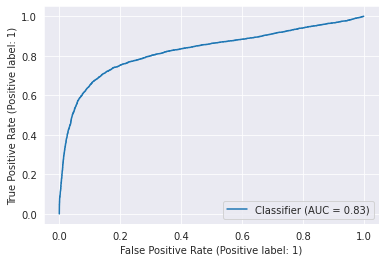

In [ ]:
RocCurveDisplay.from_predictions(labels_nice,[np.mean(s) for s in sports_scores])

In [ ]:
score = roc_auc_score(labels,[np.mean(s) for s in world_scores])
score

0.8137095337026776

In [ ]:
average_precision_score([l[0] for l in labels],[np.mean(s) for s in sports_scores])

0.707016382510804

In [ ]:
labels_nice = [l[0] for l in labels]

In [ ]:
import pickle
with open("/content/drive/MyDrive/scores_sports_pretrained_full.pickle", "wb+") as f:
  pickle.dump(sports_scores, f)
with open("/content/drive/MyDrive/labels_sports_pretrained_full.pickle", "wb+") as f:
  pickle.dump(labels_nice, f)

NameError: ignored

In [ ]:
both_sides_thresh = [1e-4, 1e-3, 1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
current_auc = roc_auc_score(labels_nice,[np.mean(s) for s in sports_scores])
best_auc = current_auc
min_val = -7
max_val = 2

for tr in both_sides_thresh:  
  new_scores = copy.deepcopy(sports_scores)
  for score in new_scores:
    for idx, el in enumerate(score):
      if el >= tr:
        score[idx] = max_val
      elif el < tr:
        score[idx] = min_val
      else: 
        print(el)
  new_auc = roc_auc_score(labels_nice, [np.sum(s) for s in new_scores])
  fpr, tpr, thresholds = roc_curve(labels_nice,[np.sum(s) for s in new_scores])
  print("-"*50)
  print(f"best thresh is {thresholds[np.argmax(tpr - fpr)]}")
  print(f"auc is {new_auc}")
  print([np.sum(s) for s in new_scores])
  print(f"map is {average_precision_score(labels_nice,[np.sum(s) for s in new_scores])}")
  if new_auc > best_auc:
    RocCurveDisplay.from_predictions(labels_nice,[np.sum(s) for s in new_scores])
    best_auc = new_auc
    best_max_thresh = tr
print(best_max_thresh)

Roc-auc is 0.8125412049861496
best thresh is -1.0
mean of outliers is -11.512280701754387
median of outliers is -10.0
mean of inliers is 10.327631578947368
median of liners is 8.0
outliers after thresh 0.26973684210526316
inliers after thresh 0.255


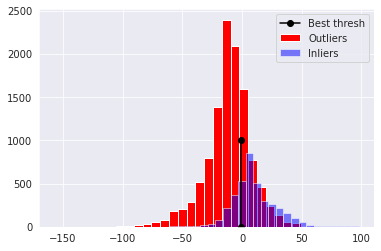

In [ ]:
labels = np.array(labels)
labels_nice = labels
best_max_thresh = 1e-3
max_val = 1
min_val = -4
new_scores = copy.deepcopy(sci_scores)
for idx, score in enumerate(new_scores):
  for ids, el in enumerate(score):
    if el >= best_max_thresh:
      score[ids] = max_val
    else:
      score[ids] = min_val
new_scores = np.array([np.sum(s) for s in new_scores])
inliers = new_scores[np.where(labels == 1)[0]] 
outliers = new_scores[np.where(labels == 0)[0]]
print(f"Roc-auc is {roc_auc_score(labels_nice, new_scores)}")
fpr, tpr, thresholds = roc_curve(labels_nice,new_scores)
bthr = thresholds[np.argmax(tpr - fpr)]
print(f"best thresh is {thresholds[np.argmax(tpr - fpr)]}")
plt.hist(outliers, bins=30, color="red")
plt.hist(inliers, bins=30, color="blue", alpha=0.5)
plt.plot([bthr, bthr], [0, 1000], marker = 'o', color="black")
print(f"mean of outliers is {np.mean(outliers)}")
print(f"median of outliers is {np.median(outliers)}")
print(f"mean of inliers is {np.mean(inliers)}")
print(f"median of liners is {np.median(inliers)}")
print(f"outliers after thresh {len(outliers[outliers>=bthr])/len(outliers)}")
print(f"inliers after thresh {len(inliers[inliers<=bthr])/len(inliers)}")
# sn.displot(inliers,  stat="probability")
# sn.displot(inliers, kind="kde")
# sn.displot(outliers,  stat="probability", color="red")
# plt.plot([bthr, bthr], [0, 0.08], marker = 'o', color="black")
# sn.displot(outliers, kind="kde", color="red")
plt.legend(['Best thresh', 'Outliers', 'Inliers'])
plt.show()

Roc-auc is 0.6414025854108957


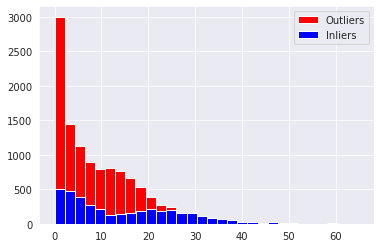

In [ ]:
labels = np.array(labels_nice)
norm_scores = copy.deepcopy(sports_scores)
norm_scores = np.array([np.sum(s) for s in norm_scores])
print(f"Roc-auc is {roc_auc_score(labels_nice, norm_scores)}")
plt.hist(norm_scores[np.where(labels == 0)[0]], bins=30, color="red")
plt.hist(norm_scores[np.where(labels == 1)[0]], bins=30, color="blue")
plt.legend(['Outliers', 'Inliers'])
# plt.plot([-14, 0], [-14, 3500], marker = 'o', color="black")
plt.show()

Roc-auc is 0.8157140120036934
0.5398853579181082
0.3228033466979745


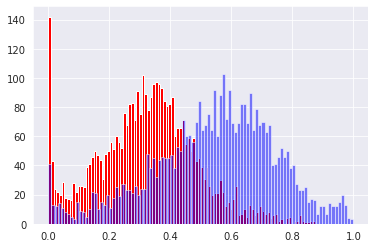

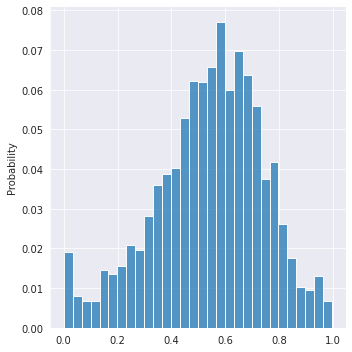

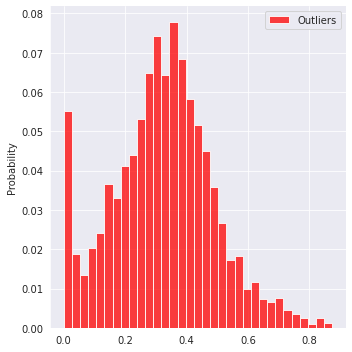

In [ ]:
labels = np.array(labels)
norm_scores = copy.deepcopy(business_scores)
norm_scores = np.array([np.mean(s) for s in norm_scores])
print(f"Roc-auc is {roc_auc_score(labels_nice, norm_scores)}")
plt.hist(norm_scores[np.where(labels == 0)[0]], bins=100, color="red")
plt.hist(norm_scores[np.where(labels == 1)[0]], bins=100, color="blue",alpha=0.5)
sn.displot(norm_scores[np.where(labels == 1)[0]],  stat="probability")
sn.displot(norm_scores[np.where(labels == 0)[0]],  stat="probability", color="red")
print(np.mean(norm_scores[np.where(labels == 1)[0]]))
print(np.mean(norm_scores[np.where(labels == 0)[0]]))
plt.legend(['Outliers', 'Inliers'])
# plt.plot([-14, 0], [-14, 3500], marker = 'o', color="black")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


0.09398465967426972
0.2882853864272341
0.30445111026110766
0.5665147797742427
0.7625771043355392


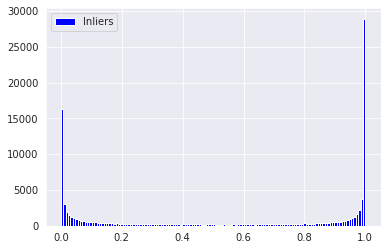

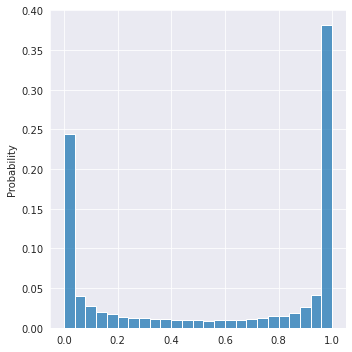

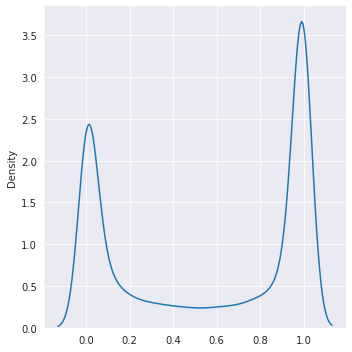

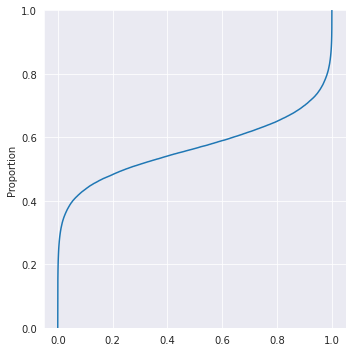

In [ ]:
labels = np.array(labels_nice)
norm_scores = np.array(copy.deepcopy(sports_scores))
norm_scores = norm_scores[np.where(labels == 1)[0]]
norm_scores = np.concatenate(norm_scores)
plt.hist(norm_scores, bins=128, color="blue")
plt.legend(['Inliers'])
print(len(norm_scores[np.where((norm_scores<=1/1000))])/len(norm_scores))
print(len(norm_scores[np.where((norm_scores >= 1/1000) & (norm_scores<=30/100))])/len(norm_scores))
print(len(norm_scores[np.where((norm_scores >= 99/100))])/len(norm_scores))
print(np.mean(norm_scores))
print(np.std(norm_scores)/np.mean(norm_scores))
sn.displot(norm_scores, stat="probability")
sn.displot(norm_scores, kind="kde")
sn.displot(1-norm_scores, kind="ecdf")

# plt.plot([-14, 0], [-14, 3500], marker = 'o', color="black")
plt.show()

In [ ]:
thr = 1e-3
max_val = 1
min_val = 1
unbalanced_terms = 1.33
labels_np = np.array(labels)
best_roc = None
best_new = None
best_anomaly = None
business_score_np = np.array(sci_scores)
for r in range(-1, -20, -1):
  min_val = max_val * r
  new_scores = copy.deepcopy(business_score_np)
  new_scores = new_scores[np.where(labels_np == 1)[0]]
  anomaly_scores = copy.deepcopy(business_score_np)
  anomaly_scores = anomaly_scores[np.where(labels_np == 1)[0]]
  for score in new_scores:
    for idx, el in enumerate(score):
      if el >= thr:
        score[idx] = max_val
      else:
        score[idx] = min_val
  for score in anomaly_scores:
    for idx, el in enumerate(score):
      if el >= 1-20*thr:
        score[idx] = min_val * unbalanced_terms
      else:
        score[idx] = max_val
  new_scores = [sum(s) for s in new_scores]
  anomaly_scores = [sum(s) for s in anomaly_scores]
  labels_r = [1] * len(new_scores) + [0] * len(anomaly_scores)
  full_scores = new_scores + anomaly_scores
  print("-"*50)
  print(f"r is {r}")
  print(f"roc-auc is {roc_auc_score(labels_r, full_scores)}")
  if best_roc is None or best_roc < roc_auc_score(labels_r, full_scores):
    print(f"best r is {r}")
    best_roc = roc_auc_score(labels_r, full_scores)
    best_new = new_scores
    best_anomaly = anomaly_scores
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


--------------------------------------------------
r is -1
roc-auc is 0.7312010387811634
best r is -1
--------------------------------------------------
r is -2
roc-auc is 0.8089452216066482
best r is -2
--------------------------------------------------
r is -3
roc-auc is 0.8319489265927977
best r is -3
--------------------------------------------------
r is -4
roc-auc is 0.8417989265927978
best r is -4
--------------------------------------------------
r is -5
roc-auc is 0.8402849030470915
--------------------------------------------------
r is -6
roc-auc is 0.8340368074792244
--------------------------------------------------
r is -7
roc-auc is 0.8317352493074792
--------------------------------------------------
r is -8
roc-auc is 0.8269818559556786
--------------------------------------------------
r is -9
roc-auc is 0.8215561288088642
--------------------------------------------------
r is -10
roc-auc is 0.8196461565096953
--------------------------------------------------
r is -

In [ ]:
print(np.median([len(s) for s in sports_scores]))

21.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


0.4338564549177001
0.12783195165590225
0.2766082497994863
0.34397118628568074
0.41896040696847486


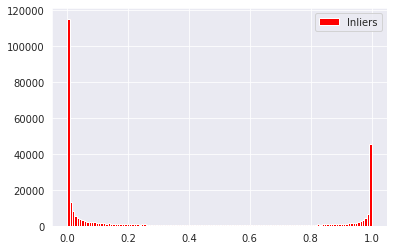

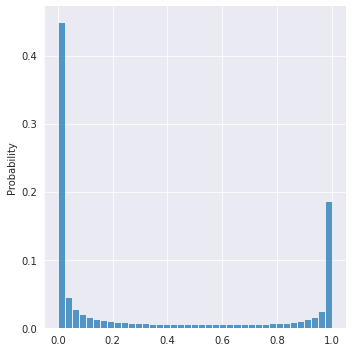

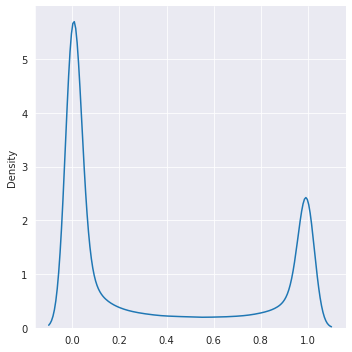

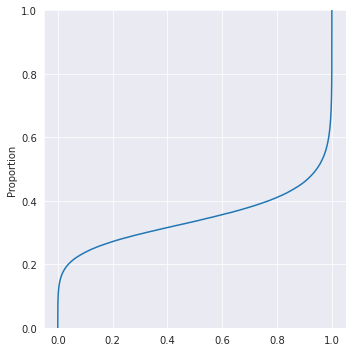

In [ ]:
labels = np.array(labels_nice)
norm_scores = np.array(copy.deepcopy(world_scores))
norm_scores = norm_scores[np.where(labels == 0)[0]]
norm_scores = np.concatenate(norm_scores)
plt.hist(norm_scores, bins=128, color="red")
plt.legend(['Inliers'])
print(len(norm_scores[np.where((norm_scores<=1/50))])/len(norm_scores))
print(len(norm_scores[np.where((norm_scores >= 28/128) & (norm_scores<=100/128))])/len(norm_scores))
print(len(norm_scores[np.where((norm_scores >= 100/128))])/len(norm_scores))
print(np.mean(norm_scores))
print(np.std(norm_scores))
sn.displot(norm_scores, stat="probability")
sn.displot(norm_scores, kind="kde")
sn.displot(1-norm_scores, kind="ecdf")

# plt.plot([-14, 0], [-14, 3500], marker = 'o', color="black")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


0.07
0.6462065180799871
0.21121862218364854
0.3268593186141524


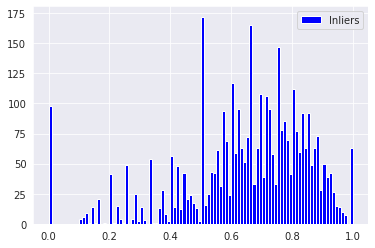

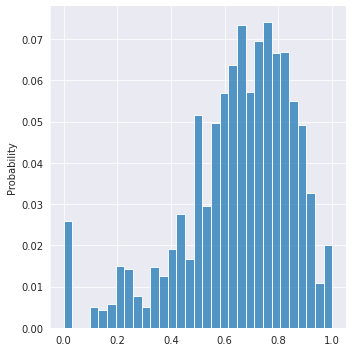

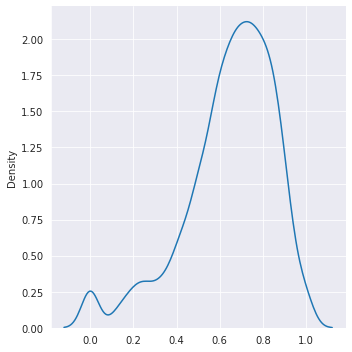

In [ ]:
labels = np.array(labels_nice)
norm_scores = np.array(copy.deepcopy(sports_scores))
norm_scores = norm_scores[np.where(labels == 1)[0]]
bad_tokens = []
for idx, score in enumerate(norm_scores):
  bad_num = 0
  for el in score:
    if el >= 99/1000:
      bad_num += 1
  bad_tokens.append(bad_num/len(score))
bad_tokens = np.array(bad_tokens)
plt.hist(bad_tokens, bins=100, color="blue")
plt.legend(['Inliers'])
print(len(bad_tokens[bad_tokens<=25/100])/len(bad_tokens))
sn.displot(bad_tokens, stat="probability")
sn.displot(bad_tokens, kind="kde")
print(np.mean(bad_tokens))
print(np.std(bad_tokens))
print(np.std(bad_tokens)/np.mean(bad_tokens))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


0.1362116991643454
5.4202662371756
6.628976800812332
mad is 4.066480282659858
3.4
24.209019844690136
1.222998375125309


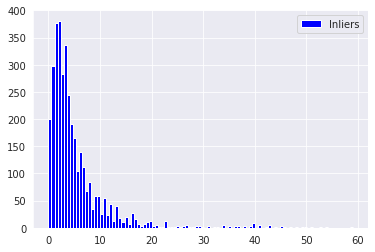

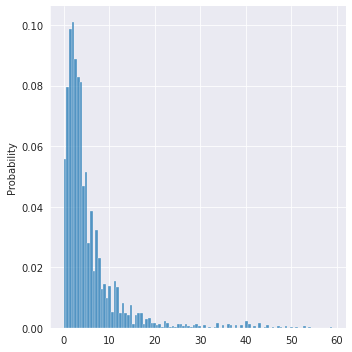

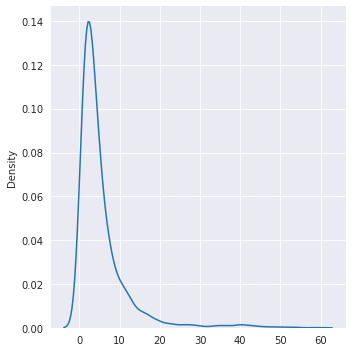

In [ ]:
labels = np.array(labels_nice)
norm_scores = np.array(copy.deepcopy(sports_scores))
norm_scores = norm_scores[np.where(labels == 1)[0]]
bad_tokens = []
for idx, score in enumerate(norm_scores):
  bad_num = 0
  good_num = 0
  for el in score:
    if el <= 2/100:
      bad_num += 1
    elif el >= 2/100:
      good_num += 1
  if good_num == 0:
    bad_tokens.append(0)
  elif bad_num == 0:
    continue
    bad_tokens.append(100)
  else:
    bad_tokens.append(good_num/bad_num)
bad_tokens = np.array(bad_tokens)
plt.hist(bad_tokens, bins=100, color="blue")
plt.legend(['Inliers'])
print(len(bad_tokens[bad_tokens>=10])/len(bad_tokens))
print(np.mean(bad_tokens[bad_tokens !=100]))
print(np.std(bad_tokens[bad_tokens !=100]))
print(f"mad is {np.mean(abs(bad_tokens - np.mean(bad_tokens)))}")
print(np.median(bad_tokens[bad_tokens !=100]))
print((np.mean(bad_tokens) - 0.5) ** 2)
print(np.std(bad_tokens)/np.mean(bad_tokens))
sn.displot(bad_tokens, stat="probability")
sn.displot(bad_tokens, kind="kde")
plt.show()

19.429976529728755
0.7932236842105264


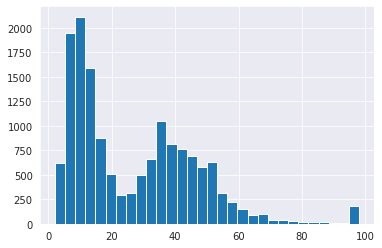

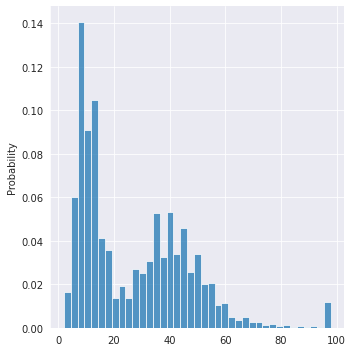

In [ ]:
lens = np.array([len(s) for s in sports_scores])
plt.hist(lens, bins=30)
sn.displot(lens, stat="probability")
print(np.std(lens))
print(len(lens[lens<=43])/len(lens))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


0.9985549132947977
1.4476828711253953
0.8981028242244725
mad is 0.9684038203307973
1.0691734709361371


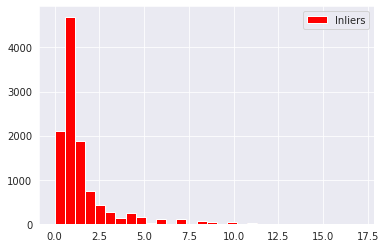

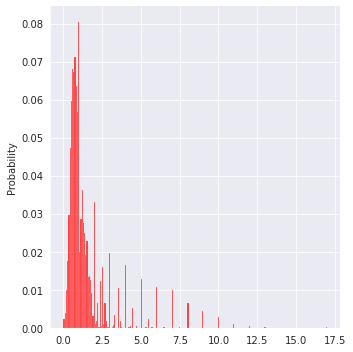

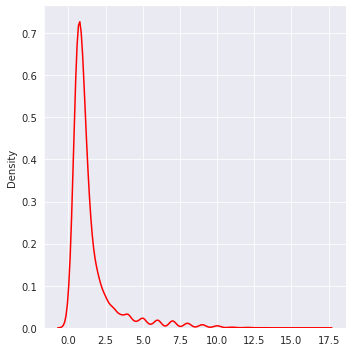

In [ ]:
labels = np.array(labels_nice)
norm_scores = np.array(copy.deepcopy(sports_scores))
norm_scores = norm_scores[np.where(labels == 0)[0]]
bad_tokens = []
for idx, score in enumerate(norm_scores):
  bad_num = 0
  good_num = 0
  for el in score:
    if el <= 2/100:
      bad_num += 1
    if el >= 2/100:
      good_num += 1
  if good_num == 0:
    continue
    bad_tokens.append(100)
  elif bad_num == 0:
    bad_tokens.append(0)
  else:
    bad_tokens.append(bad_num/good_num)
bad_tokens = np.array(bad_tokens)
plt.hist(bad_tokens, bins=30, color="red")
plt.legend(['Inliers'])
print(len(bad_tokens[bad_tokens>=2/100])/len(bad_tokens))
print(np.mean(bad_tokens[bad_tokens !=100]))
print((np.mean(bad_tokens) - 0.5) ** 2)
print(f"mad is {np.mean(abs(bad_tokens - np.mean(bad_tokens)))}")
print(np.std(bad_tokens)/np.mean(bad_tokens))
sn.displot(bad_tokens, stat="probability", color="red")
sn.displot(bad_tokens, kind="kde", color="red")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


0.9868421052631579
0.7414100683131053
0.058278821082938165
0.26214218329224076


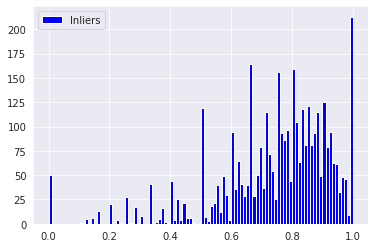

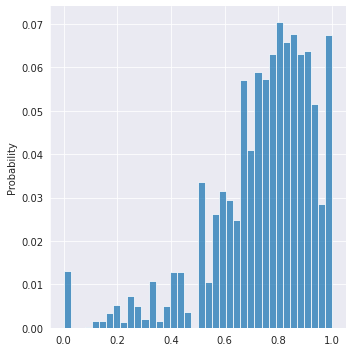

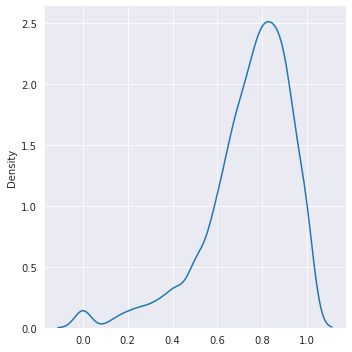

In [ ]:
labels = np.array(labels_nice)
norm_scores = np.array(copy.deepcopy(sports_scores))
norm_scores = norm_scores[np.where(labels == 1)[0]]
bad_tokens = []
for idx, score in enumerate(norm_scores):
  bad_num = 0
  for el in score:
    if el >= 2/100:
      bad_num += 1
  bad_tokens.append(bad_num/len(score))
bad_tokens = np.array(bad_tokens)
plt.hist(bad_tokens, bins=100, color="blue")
plt.legend(['Inliers'])
print(len(bad_tokens[bad_tokens>=2/100])/len(bad_tokens))
print(np.mean(bad_tokens))
print((np.mean(bad_tokens) - 0.5) ** 2)
print(np.std(bad_tokens)/np.mean(bad_tokens))
sn.displot(bad_tokens, stat="probability")
sn.displot(bad_tokens, kind="kde")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


0.9145614035087719
0.4814096789279471
0.0003456000375620135


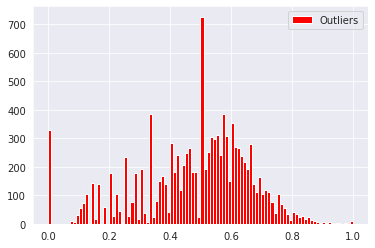

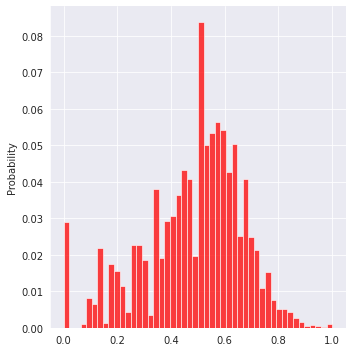

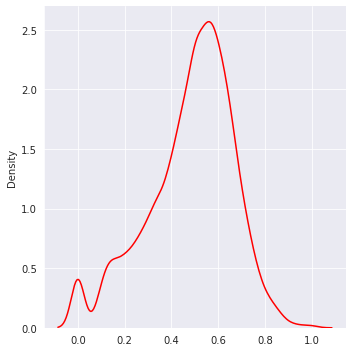

In [ ]:
labels = np.array(labels_nice)
norm_scores = np.array(copy.deepcopy(sports_scores))
norm_scores = norm_scores[np.where(labels == 0)[0]]
bad_tokens = []
for idx, score in enumerate(norm_scores):
  bad_num = 0
  for el in score:
    if el >= 2/100:
      bad_num += 1
  bad_tokens.append(bad_num/len(score))
bad_tokens = np.array(bad_tokens)
plt.hist(bad_tokens, bins=100, color="red")
plt.legend(['Outliers'])
print(len(bad_tokens[bad_tokens>=20/100])/len(bad_tokens))
print(np.mean(bad_tokens))
print((np.mean(bad_tokens) - 0.5) ** 2)
sn.displot(bad_tokens, stat="probability", color="red")
sn.displot(bad_tokens, kind="kde", color="red")
plt.show()

In [ ]:
sum = np.sum(norm_scores[np.where(labels == 1)[0]])
mean = np.mean(norm_scores[np.where(labels == 1)[0]])
print(sum, mean)

1960.0899821663413 0.5158131532016688


In [ ]:
print(norm_scores[:10])

[0.39668199 0.64620447 0.56230796 0.4822119  0.34106013 0.37498388
 0.12042947 0.41970181 0.42435439 0.49099194]


0.5158131532016688
0.1969367088106912


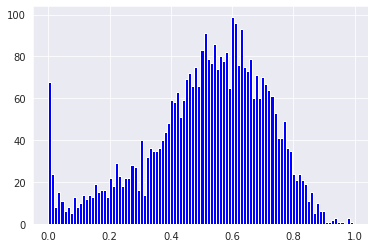

0.28686784436042295
0.15242287449566266


In [ ]:
print(np.mean(norm_scores[np.where(labels == 1)[0]]))
print(np.std(norm_scores[np.where(labels == 1)[0]]))
normed_arr = norm_scores[np.where(labels == 1)[0]]
#print((np.std(normed_arr)*0.5)/np.std(normed_arr))
normed_arr = (normed_arr - np.mean(normed_arr)) / np.std(normed_arr)
plt.hist(norm_scores[np.where(labels == 1)[0]], bins=100,color="blue")
plt.show()
#print(np.mean(normed_arr))
print(np.mean(norm_scores[np.where(labels == 0)[0]]))
print(np.std(norm_scores[np.where(labels == 0)[0]]))

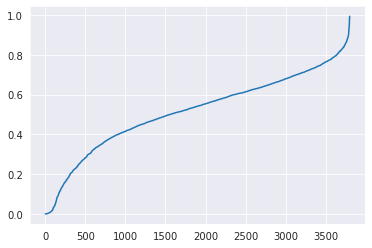

In [ ]:
mean = np.mean(norm_scores[np.where(labels == 1)[0]])
std = np.std(norm_scores[np.where(labels == 1)[0]])

aux = norm_scores[np.where(labels == 1)[0]]
aux = sorted(aux)

plt.plot(aux)
plt.show()

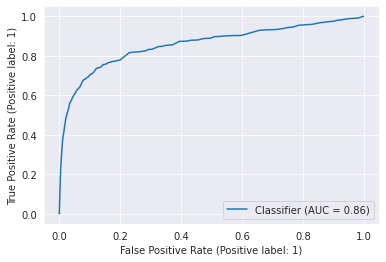

In [ ]:
tr = 0.01
min_val = 0
max_val = 1

new_scores = copy.deepcopy(sports_scores)
for score in new_scores:
  for idx, el in enumerate(score):
    if el >= tr:
      score[idx] = max_val
    elif el < tr:
      score[idx] = min_val
    else: 
      print(el)
RocCurveDisplay.from_predictions(labels_nice,[np.mean(s) for s in new_scores])

In [ ]:
max_ranges = [1.5*1e-3, 1e-3, 1e-2, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
max_val = 2.5
min_ranges = [1e-2, 1e-3, 1e-4, 2*1e-4, 1.5*1e-4]
min_val = -5.999

current_auc = roc_auc_score(labels_nice,[np.mean(s) for s in sports_scores])
best_auc = current_auc
best_max_thresh = None
best_min_thresh = None
for mr in max_ranges:
  new_scores = copy.deepcopy(sports_scores)
  for score in new_scores:
    for idx, el in enumerate(score):
      if el >= mr:
        score[idx] = max_val
  new_auc = roc_auc_score(labels_nice,[np.mean(s) for s in new_scores])
  print(new_auc)
  if new_auc > best_auc:
    RocCurveDisplay.from_predictions([l[0] for l in labels],[np.mean(s) for s in new_scores])
    best_auc = new_auc
    best_max_thresh = mr
print(best_max_thresh)
print("-"*50)
for mr in min_ranges:
  new_scores = copy.deepcopy(sports_scores)
  for score in new_scores:
    for idx, el in enumerate(score):
      if el <= mr:
        score[idx] = min_val
  new_auc = roc_auc_score(labels_nice,[np.mean(s) for s in new_scores])
  print(new_auc)
  if new_auc > best_auc:
    best_auc = new_auc
    best_min_thresh = mr
print(best_min_thresh)
print("-"*50)

for mr in max_ranges:
  new_scores = copy.deepcopy(sports_scores)
  for score in new_scores:
    for idx, el in enumerate(score):
      if el >= mr:
        score[idx] = max_val
  new_auc = roc_auc_score(labels_nice,[np.mean(s) for s in new_scores])
  for minr in min_ranges:
    new_scores = copy.deepcopy(sports_scores)
    for score in new_scores:
      for idx, el in enumerate(score):
        if el <= minr:
          score[idx] = min_val
        elif el >= mr:
          score[idx] = max_val
    new_auc = roc_auc_score(labels_nice,[np.mean(s) for s in new_scores])
    print(new_auc)
    if new_auc > best_auc:
      RocCurveDisplay.from_predictions([l[0] for l in labels],[np.mean(s) for s in new_scores])
      best_auc = new_auc
      best_max_thresh = mr
      best_min_thresh = minr
  
print(best_max_thresh)
print(best_min_thresh)

0.8596052631578948


IndexError: ignored

In [ ]:
print(best_auc)

0.8727879732225301


In [ ]:
# scores = []
# corect_labels = []
# for idx, batch in enumerate(dl_test):
#   texts, labels = batch
#   for i in range(2):
#     text = texts[i]
#     label = labels[i]
#     scores.append(calculate_normality_score(model, text))
#     corect_labels.append(label.item())
#   print(f"Finish {idx} / {len(dl_test)} batches")
#   if idx > 10:
#     break
#   #corect_labels += labels.tolist()

In [ ]:
scores = []
corect_labels = []
for idx, batch in enumerate(dl_sports_test):
  texts, labels = batch

  texts = texts.to(device)
  labels = labels.to(device)
  for text in tqdm(texts):
    scores.append(multiple_masked_tokens_normality_score(model, text, 6))
    
  print(f"Finished {idx} / {len(dl_sports_test)} batches")
  corect_labels += labels.tolist()

In [ ]:
corect_labels = [c[0] for c in corect_labels]

In [ ]:
print(scores)
print(corect_labels)

[0.11264115586382104, 0.27807282457231647, 0.30235189126016426, 0.22249602851291989, 0.1675309630137255, 0.23263661678807446, 0.05414697003806168, 0.23829731351780278, 0.2719548442303979, 0.3441783357871542, 0.0018118941188731696, 0.39857975715166716, 0.3965087560209213, 0.543322037692929, 0.532706287514884, 0.46833942301455117, 0.514263299936439, 0.49885690993259607, 0.04364857142078336, 0.44280695383506985, 0.23881973583215418, 0.6316412780767038, 0.2608611151597209, 0.46612204609726343, 0.3343321446979341, 0.39300470335581394, 0.4420281613133251, 0.31173371523346227, 0.3666549646173394, 0.3877553083181311, 0.3500746293570349, 0.41709389589173834, 0.12782689435770017, 0.2548587722472344, 0.008679748750139637, 0.4025689378026679, 0.10550378270870299, 0.31936958004752897, 0.454363734097989, 0.5527222776699242, 0.3405938004078861, 0.5192471949335506, 0.017045010787721065, 0.32782224440912006, 0.12893931952982843, 0.5179341846323084, 0.22995775765555967, 0.21889492880219613, 0.3307307546

In [ ]:
score = roc_auc_score(labels,[np.sum(s) for s in sports_scores])
score

0.6414025854108957

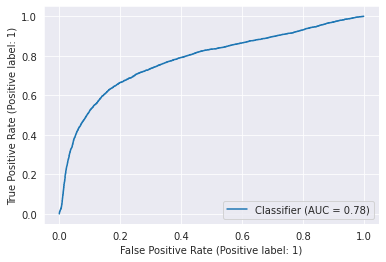

In [ ]:
RocCurveDisplay.from_predictions(corect_labels,scores)

In [ ]:
# import copy
# from transformers import BertForMaskedLM, BertTokenizerFast
# import torch

# # tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# # model = AnomalyDetectionModel()
# # model.load_state_dict(torch.load("trained_bert_sports_agnews.pt"))
# model1 = copy.deepcopy(model)
# model1.to("cpu")

# model2 = BertForMaskedLM.from_pretrained('bert-base-cased')
# text = "Dr. Mario Roederer and Adam Treister at Stanford University wrote FlowJo, Mac OS X analysis software for flow cytometers, high-speed, automated microscopes. Today, some 15,000 to 20,000 cytometers in use are Mac based. Aug 3"
# inputs  =  tokenizer(text,  return_tensors="pt", add_special_tokens = True, truncation=True, pad_to_max_length = True,
#                                          return_attention_mask = True,  max_length=100)
# input_ids = inputs['input_ids']
# print(tokenizer.convert_ids_to_tokens(input_ids[0]))
# labels  = copy.deepcopy(input_ids) #this is the part I changed
# tok_id = 14
# print(tokenizer.convert_ids_to_tokens([input_ids[0][tok_id]]))
# old_tok = input_ids[0][tok_id].item()
# input_ids[0][tok_id] = tokenizer.mask_token_id
# labels[input_ids != tokenizer.mask_token_id] = -100 

# outputs = model1(input_ids, labels=labels)
# # outputs =  model2(input_ids = input_ids, attention_mask = inputs['attention_mask'] , token_type_ids=inputs['token_type_ids'] , labels=labels)
# loss = outputs.loss
# scores = outputs.logits
# print('loss',loss)
# print(tokenizer.convert_ids_to_tokens([old_tok]))
# pred = torch.argmax( scores[0][tok_id]).item()
# logSoftmax = torch.nn.LogSoftmax(dim=1)
# softmax = torch.nn.Softmax()
# NLLLos = torch.nn.NLLLoss()
# print("predicted token:", pred, tokenizer.convert_ids_to_tokens([pred])  )
# print(NLLLos( logSoftmax(torch.unsqueeze(scores[0][tok_id], 0)), torch.tensor([pred]))) #the same as F.cross_entropy(scores.view(-1, tokenizer.vocab_size), labels.view(-1))
# print(softmax(scores[0][tok_id])[pred])
# print(softmax(scores[0][tok_id])[old_tok])
# # print(NLLLos( logSoftmax(torch.unsqueeze(scores[0][16], 0)), torch.tensor([old_tok]))) #the same as F.cross_entropy(scores.view(-1, tokenizer.vocab_size), labels.view(-1))